# 06: Thunderstorm Wind Average Magnitude Forecast | Region: U.S. Northeast
---

## 1. Imports

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from datetime import datetime

pd.set_option('display.max_columns', None)

---
## 2. Loading Data

In [26]:
all_storms = pd.read_csv('../data/all_storms_dt_damage_clean.csv')

/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


---
## 3. Organizing Data

### 3.1. Dropping Columns

In [27]:
all_storms = all_storms[['state', 'region', 'event_type', 'begin_date_time', 'magnitude']]

In [28]:
all_storms

,state,region,event_type,begin_date_time,magnitude
0,Oklahoma,South,Tornado,1950-04-28 14:45:00,0.0
1,Texas,South,Tornado,1950-06-19 20:40:00,0.0
2,Indiana,Midwest,Tornado,1950-07-19 14:30:00,0.0
3,Indiana,Midwest,Tornado,1950-07-19 17:45:00,0.0
4,Colorado,West,Tornado,1950-07-22 15:07:00,0.0
...,...,...,...,...,...
1740591,Arkansas,South,Winter Storm,2022-02-02 18:45:00,NaN
1740592,Arkansas,South,Winter Weather,2022-02-03 02:50:00,NaN
1740593,Arkansas,South,Winter Storm,2022-02-03 01:00:00,NaN
1740594,Massachusetts,Northeast,Heavy Snow,2022-02-25 00:00:00,NaN


In [29]:
# Casting the BEGIN_DATE_TIME to a datetime dtype
all_storms['begin_date_time'] = pd.to_datetime(all_storms['begin_date_time'])

# Setting begin_date_time as the index
all_storms.set_index('begin_date_time', inplace=True)

# Sorting the index
all_storms.sort_index(inplace=True)

In [30]:
# Dropping all rows with a missing value in the magnitude column

all_storms = all_storms.dropna(subset=['magnitude'])

### 3.2. Subsetting to Thunderstorm Wind in the Northeast (1996-2022)

In [31]:
ts_wind = all_storms[all_storms['event_type'] == 'Thunderstorm Wind']

ts_wind = ts_wind[ts_wind['region'] == 'Northeast']

ts_wind = ts_wind[ts_wind.index > '1996']

In [32]:
ts_wind

,state,region,event_type,magnitude
begin_date_time,,,,
1996-01-19 14:32:00,New York,Northeast,Thunderstorm Wind,54.0
1996-01-19 15:07:00,Connecticut,Northeast,Thunderstorm Wind,53.0
1996-01-19 15:55:00,New York,Northeast,Thunderstorm Wind,52.0
1996-02-24 01:30:00,Pennsylvania,Northeast,Thunderstorm Wind,50.0
1996-02-24 01:30:00,Pennsylvania,Northeast,Thunderstorm Wind,50.0
...,...,...,...,...
2022-03-31 19:20:00,Pennsylvania,Northeast,Thunderstorm Wind,52.0
2022-03-31 19:23:00,Pennsylvania,Northeast,Thunderstorm Wind,52.0
2022-03-31 19:36:00,Pennsylvania,Northeast,Thunderstorm Wind,50.0


### 3.3. Resampling to Quarterly Averages

In [33]:
# Helper plotting function

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
   
    plt.figure(figsize=(10,6))
    
    for col in cols:
        plt.plot(df[col])

    plt.title(title, fontsize=14)
    plt.xlabel(xlab, fontsize=12)
    plt.ylabel(ylab, fontsize=12)
    
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12);

In [34]:
# Resampling to quarterly averages
ts_wind = ts_wind.resample('Q').mean()

# Renaming the column to 'avg_mag'
ts_wind = ts_wind.rename(columns={'magnitude': 'avg_mag'})

In [35]:
# Checking for null values as a result of the resampling

ts_wind.isnull().sum()

avg_mag    3
dtype: int64

In [36]:
# Using the interpolate function to fill in the missing values with the mean of the previous value and the next value

ts_wind = ts_wind.interpolate()

In [37]:
ts_wind

,avg_mag
begin_date_time,
1996-03-31,51.333333
1996-06-30,55.028986
1996-09-30,51.136000
1996-12-31,50.647059
1997-03-31,54.235294
...,...
2021-03-31,51.156863
2021-06-30,51.587940
2021-09-30,51.428723


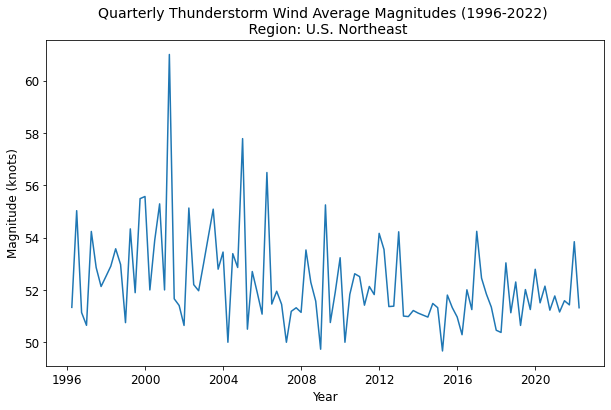

In [38]:
# Quarterly Thunderstorm Wind Average Magnitudes (1996-2022) - Region: U.S. Northeast

plot_series(ts_wind, ['avg_mag'], title='Quarterly Thunderstorm Wind Average Magnitudes (1996-2022) \n Region: U.S. Northeast', xlab='Year', ylab='Magnitude (knots)', steps=4)

## 4. Trends

### 4.1. Seasonality

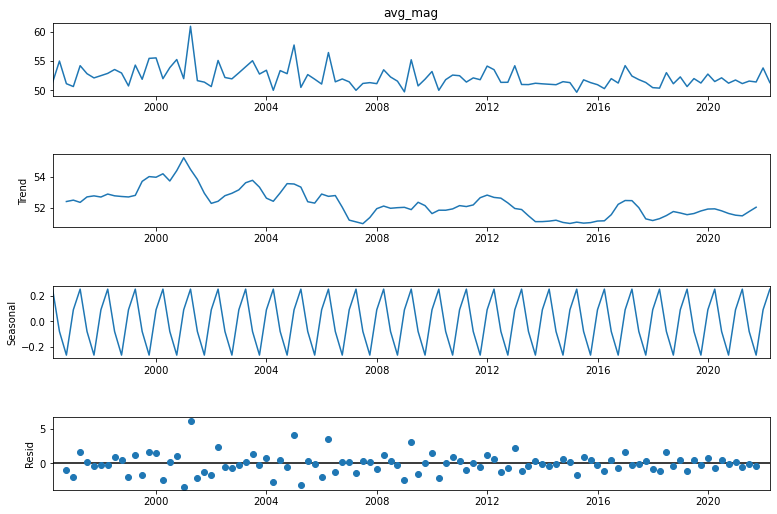

In [39]:
decomp = seasonal_decompose(ts_wind['avg_mag'])

decomp.plot();
fig = plt.gcf()
fig.set_size_inches(12, 8)

In the trend component, we see that the averages fluctuate quite a bit, but in general seem to decrease over time.

In the seasonal component, we see that there appears to be some seasonality detected. But this seasonal view can sometimes be misleading, so I'll need to run some additional diagnostics.

In the resid component, we see that there's quite a bit of variability, more so toward the beginning of the 26 year timeframe, that can not be explained by the model.

### 4.2. Autocorrelation

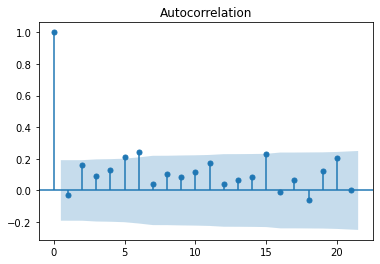

In [40]:
plot_acf(ts_wind['avg_mag']);

For trend, the lack of large and positive values in the earlier lags indicate and confirm that there is no real trend in the data.

For seasonality, the fluctuations do not occur with a fixed and known frequency and therefore, indicates that there is no seasonality in the data.

For lags, it seems that not using any will lead to best results, as the initial lags do not extend 

### 4.3. Partial Autocorrelation

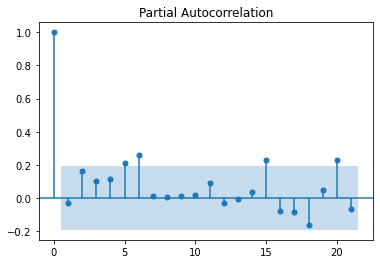

In [41]:
plot_pacf(ts_wind['avg_mag']);

For seasonality, as seen in the autocorrelation, the fluctuations do not occur with a fixed and known frequency and therefore, confirms that there is no seasonality present.

For lags, it seems that using no lags in the model will lead to optimal model performance.

### 4.4. Stationarity

In [42]:
# Dickey-Fuller Stationarity Test

adfuller(ts_wind['avg_mag'])

(-2.049888794081758,
 0.26513572183580547,
 5,
 99,
 {'1%': -3.498198082189098,
  '5%': -2.891208211860468,
  '10%': -2.5825959973472097},
 362.9011034946558)

The first 2 statistics of the test results tell me that the data is not stationary.

The 'test statistic', the first statistic, needs to be less than the critical values, which are the 1%, 5% and 10% values, and it is not. The p-value, the second statistic, needs to be less than the alpha of 0.05, and it is not. As a result, I'll need to difference the data.

### 4.5. Differencing

#### 4.5.1. Once Differenced

In [43]:
# Differencing the data

ts_wind['first_diff'] = ts_wind['avg_mag'].diff()

In [44]:
# Dropping any null values as a result of the differencing

ts_wind.dropna(inplace=True)

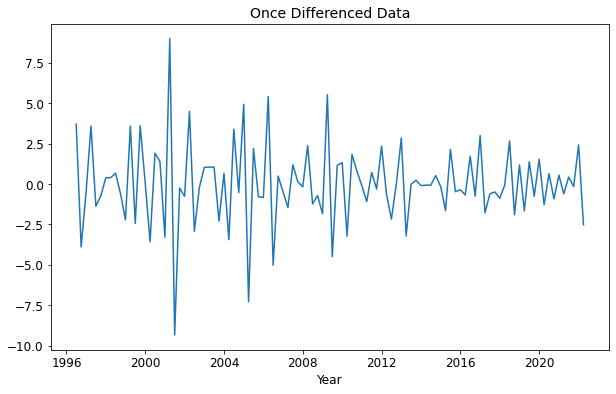

In [45]:
plot_series(ts_wind, ['first_diff'], title='Once Differenced Data', xlab='Year', steps=4)

In [46]:
# Checking for the stationarity of the once differenced data

adfuller(ts_wind['first_diff'])

(-9.325113218280487,
 9.65738949505719e-16,
 4,
 99,
 {'1%': -3.498198082189098,
  '5%': -2.891208211860468,
  '10%': -2.5825959973472097},
 360.1586753583234)

The test statistic is now less than the critical values and the p-value is less than the alpha of 0.05. The data is now stationary and can be modeled on with ARIMA.

---
## 5. ARIMA Time Series Modeling

### 5.1. Train-Test Split

Considering the few observations that I have to work with, I'll be using 90% of the data to train on.

In [47]:
y_train, y_test = train_test_split(ts_wind['first_diff'], test_size=0.1, shuffle=False)

### 5.2. GridSearch for best AIC, p & q

Because I needed to difference the data once, I know that the d parameter for the ARIMA model is 1. Given that, I'll run a GridSearch for the most optimal p & q.

In [48]:
best_aic = 1_000_000_000
best_p = 0
best_q = 0

for p in range(5):
    for q in range(5):

        try:
            
            arima = ARIMA(endog = y_train.astype(float).dropna(),
                         order=(p, 1, q))
            
            model = arima.fit(method_kwargs={"warn_convergence": False})

            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            if model.aic < best_aic:
                best_aic = model.aic
                best_p = p
                best_q = q

        except Exception as e:
            print(e)
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

The AIC for ARIMA(0,1,0) is: 546.2210981919493
The AIC for ARIMA(0,1,1) is: 447.4907863690653
The AIC for ARIMA(0,1,2) is: 382.83908499795734


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(0,1,3) is: 382.2399299535233
The AIC for ARIMA(0,1,4) is: 384.2320898903398
The AIC for ARIMA(1,1,0) is: 481.8476490148699
The AIC for ARIMA(1,1,1) is: 411.5785895751836
The AIC for ARIMA(1,1,2) is: 382.29290800444466
The AIC for ARIMA(1,1,3) is: 386.35914745145453
The AIC for ARIMA(1,1,4) is: 385.38866281772005
The AIC for ARIMA(2,1,0) is: 455.02505674943217
The AIC for ARIMA(2,1,1) is: 402.47066071083975
The AIC for ARIMA(2,1,2) is: 384.2838798312509
The AIC for ARIMA(2,1,3) is: 385.31313088038735
The AIC for ARIMA(2,1,4) is: 389.7279631251136
The AIC for ARIMA(3,1,0) is: 444.64466746753453
The AIC for ARIMA(3,1,1) is: 398.45221326871905
The AIC for ARIMA(3,1,2) is: 385.9387189994883
The AIC for ARIMA(3,1,3) is: 387.294884229894
The AIC for ARIMA(3,1,4) is: 388.3169581334107
The AIC for ARIMA(4,1,0) is: 435.0196254113256
The AIC for ARIMA(4,1,1) is: 391.4336120204227
The AIC for ARIMA(4,1,2) is: 400.6873524906806
The AIC for ARIMA(4,1,3) is: 388.5791023337702
The AI

The p, d, q combination that returned the lowest AIC was when p=0, d=1, and q=3. This means that the model will perform best with the use of 0 lags, once differenced data and a moving average window of 3. This combination, referred to as an order,  will be referenced as (0,1,3) and will be used as the ARIMA model order parameter.

### 5.3. Instantiate & Fit

In [49]:
model = ARIMA(endog=y_train.astype(float).dropna(), order = (0,1,3))

arima = model.fit()

### 5.4. Test Forecast

In [50]:
# Checking how many quarters were considered as test data with a test size of 10%

len(y_test)

11

In [51]:
# Generating the forecast for those 11 quarters

forecast = arima.forecast(steps=11)
forecast

2019-09-30   -0.657811
2019-12-31    0.073633
2020-03-31   -0.015629
2020-06-30   -0.015629
2020-09-30   -0.015629
2020-12-31   -0.015629
2021-03-31   -0.015629
2021-06-30   -0.015629
2021-09-30   -0.015629
2021-12-31   -0.015629
2022-03-31   -0.015629
Freq: Q-DEC, Name: predicted_mean, dtype: float64

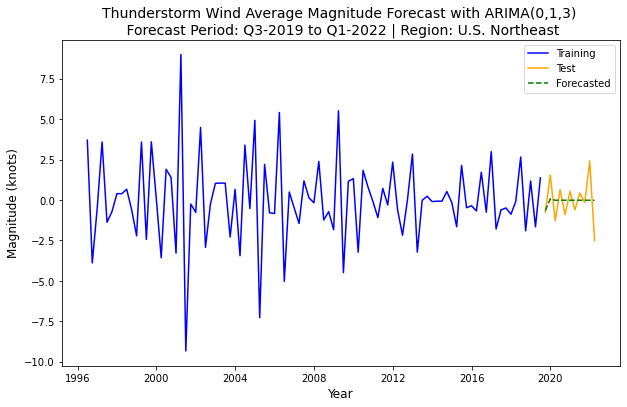

In [52]:
# Thunderstorm Wind Average Magnitude Forecast with ARIMA(0,1,3) - Forecast Period: Q3-2019 to Q1-2022 | Region: U.S. Northeast

plt.figure(figsize=(10,6))
plt.plot(y_train.index, y_train, color='blue', label='Training')
plt.plot(y_test.index, y_test, color='orange', label='Test')
plt.plot(y_test.index, forecast, color='green', label='Forecasted', linestyle='--')

plt.title(label = 'Thunderstorm Wind Average Magnitude Forecast with ARIMA(0,1,3) \n Forecast Period: Q3-2019 to Q1-2022 | Region: U.S. Northeast', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Magnitude (knots)', fontsize=12)

plt.legend();

Visually, the model does not seem to have forecasted very well. It did not try to follow the fluctuations, and went straight to forecasting the mean.

### 5.5. Test Evaluation

In [53]:
r2 = r2_score(y_test, forecast)
print('R2: ' + str(r2))

R2: 0.04196807219977783


The model does not do well in explaining the variability of the data, and explains why the model went straight to forecasting the mean.

In [54]:
# Root mean squared error

rmse = mean_squared_error(y_test, forecast, squared=False)
print('RMSE: ' + str(rmse))

RMSE: 1.2825817873542027


In [55]:
ts_wind.describe()

,avg_mag,first_diff
count,104.000000,104.000000
mean,52.291927,-0.000132
std,1.757027,2.521625
min,49.666667,-9.339535
25%,51.205037,-0.961372
50%,51.867041,-0.135067
75%,52.978972,1.177186
max,61.000000,9.000000


The RMSE of 1.28 did not exceed the standard deviation of 1.52. This model's forecasts are reliable by these evaluation metric's standards.